In [6]:
# Let's first load and inspect the uploaded dataset to understand its structure and format
import pandas as pd

# Load the dataset from the file path
file_path = r'Dataset\train_data.csv'
train_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
train_data.head()


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,...,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,1.566798,5,-10.204955,-7.834756,8.602101,14923.0,13792.0,453.8,5976.6,...,0.147350,58.272095,0.004092,0.165044,0.002987,0.386462,89.0,83.0,42.0,11.0
1,0,1.207494,5,-10.355758,-7.848937,8.956374,14544.0,13792.0,474.3,5821.2,...,0.059672,57.966413,0.003753,0.164383,0.002933,0.386393,89.0,83.0,42.0,11.0
2,0,0.952193,5,-10.345631,-7.847406,8.932195,14475.0,13792.0,474.6,5796.2,...,0.039258,57.907599,0.003576,0.164352,0.002967,0.386381,89.0,83.0,42.0,11.0
3,0,0.579669,5,-10.337809,-7.845880,8.913444,14579.0,13792.0,472.7,5838.9,...,0.022066,57.993905,0.003298,0.164309,0.002918,0.386400,89.0,83.0,40.0,14.0
4,0,0.257806,5,-10.391260,-7.852942,9.036838,14510.0,13792.0,478.7,5811.1,...,0.015075,57.946717,0.003670,0.164172,0.003220,0.386388,89.0,83.0,40.0,14.0


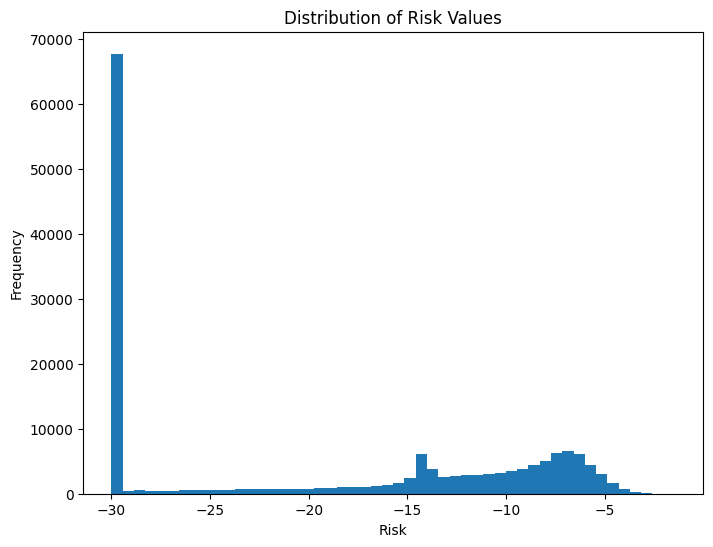

0.10   -30.000000
0.25   -30.000000
0.50   -17.870632
0.75    -9.173294
0.90    -6.576148
0.95    -5.733063
0.99    -4.480784
Name: risk, dtype: float64

In [7]:
# Let's inspect the distribution of the `risk` column to find an appropriate threshold
import matplotlib.pyplot as plt

# Plotting the distribution of the risk values
plt.figure(figsize=(8, 6))
train_data['risk'].hist(bins=50)
plt.title('Distribution of Risk Values')
plt.xlabel('Risk')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Also, let's calculate some percentiles to understand the spread
risk_percentiles = train_data['risk'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
risk_percentiles


In [8]:
# Adding a binary label for collision based on the chosen threshold for `risk` (-9.0)
# If risk is greater than -9.0, it will be considered a potential collision (label = 1), otherwise no collision (label = 0)
threshold = -9.0
train_data['collision_label'] = (train_data['risk'] > threshold).astype(int)

# Show the first few rows to verify
train_data[['risk', 'collision_label']].head()


,risk,collision_label
0,-10.204955,0
1,-10.355758,0
2,-10.345631,0
3,-10.337809,0
4,-10.391260,0


In [9]:
import numpy as np

# Calculate relative distance between the satellite and debris (hypotenuse of relative position)
train_data['relative_distance'] = np.sqrt(train_data['relative_position_r']**2 + train_data['relative_position_t']**2)

# Feature: Change in relative speed (could be useful to monitor acceleration)
train_data['delta_speed'] = train_data['relative_speed'].diff()

# Feature: Time remaining until closest approach as a ratio (could be useful for LSTM)
train_data['tca_ratio'] = train_data['time_to_tca'] / train_data['time_to_tca'].max()

# Drop rows with NaN values generated by the diff function
train_data = train_data.dropna()

# Print the new dataset with added features
train_data[['relative_distance', 'delta_speed', 'tca_ratio']].head()


,relative_distance,delta_speed,tca_ratio
5,2318.290944,-10358.0,0.933745
6,3476.809768,0.0,0.795222
7,7638.463647,0.0,0.747302
8,26067.128975,0.0,0.510452
29,12494.914752,-773.0,0.993745


In [10]:


# Relative distance calculation (hypotenuse of relative position)
train_data['relative_distance'] = np.sqrt(train_data['relative_position_r']**2 + train_data['relative_position_t']**2)

# Calculate relative acceleration (rate of change of relative speed)
train_data['relative_acceleration'] = train_data['relative_speed'].diff()

# Rolling average of relative speed over last 3 time steps
train_data['rolling_avg_speed'] = train_data['relative_speed'].rolling(window=3).mean()

# Rate of change of risk
train_data['delta_risk'] = train_data['risk'].diff()

# Time-weighted distance feature
train_data['weighted_distance'] = train_data['relative_distance'] / (train_data['time_to_tca'] + 1)

# Drop rows with NaN values generated by the diff() or rolling() functions
train_data = train_data.dropna()

# Show the updated dataset with new features
train_data[['relative_distance', 'relative_acceleration', 'rolling_avg_speed', 'delta_risk', 'weighted_distance']].head()


,relative_distance,relative_acceleration,rolling_avg_speed,delta_risk,weighted_distance
7,7638.463647,0.0,3434.0,1.893185,1226.766090
8,26067.128975,0.0,3434.0,-1.825597,5703.950629
29,12494.914752,10140.0,6814.0,-0.320209,1571.670062
30,11987.933168,0.0,10194.0,0.101960,1579.161472
31,12005.124796,0.0,13574.0,0.054178,1663.160257


In [30]:
from sklearn.preprocessing import MinMaxScaler

# Select the features you want to scale
features_to_scale = ['relative_distance', 'relative_acceleration', 'rolling_avg_speed', 'delta_risk', 'weighted_distance']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the data and transform the features
train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale])

# Show the scaled features
train_data[features_to_scale].head()

import joblib

joblib.dump(scaler, 'scaler.pkl')

# Now the scaler is saved and can be loaded later in the Tkinter application.



['scaler.pkl']

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Select the features to scale
features_to_scale = ['relative_distance', 'relative_acceleration', 'rolling_avg_speed', 'delta_risk', 'weighted_distance']

# Initialize the scaler and fit on the data
scaler = MinMaxScaler()
train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale])

# Create time sequences for LSTM (e.g., sequences of length 10)
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

sequence_length = 10  # Example sequence length
X = create_sequences(train_data[features_to_scale].values, sequence_length)

# The target variable is the collision label
y = train_data['collision_label'].values[sequence_length:]

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, len(features_to_scale))))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))





Epoch 1/10


2436/2436 [==============================] - 68s 14ms/step - loss: 0.4693 - accuracy: 0.7942 - val_loss: 0.4625 - val_accuracy: 0.7832
Epoch 2/10
2436/2436 [==============================] - 32s 13ms/step - loss: 0.4227 - accuracy: 0.8154 - val_loss: 0.4341 - val_accuracy: 0.8023
Epoch 3/10
2436/2436 [==============================] - 30s 12ms/step - loss: 0.4048 - accuracy: 0.8268 - val_loss: 0.4265 - val_accuracy: 0.8196
Epoch 4/10
2436/2436 [==============================] - 32s 13ms/step - loss: 0.3902 - accuracy: 0.8342 - val_loss: 0.4683 - val_accuracy: 0.8003
Epoch 5/10
2436/2436 [==============================] - 31s 13ms/step - loss: 0.3742 - accuracy: 0.8402 - val_loss: 0.3788 - val_accuracy: 0.8358
Epoch 6/10
2436/2436 [==============================] - 31s 13ms/step - loss: 0.3609 - accuracy: 0.8469 - val_loss: 0.3713 - val_accuracy: 0.8408
Epoch 7/10
2436/2436 [==============================] - 31s 13ms/step - loss: 0.3546 - accuracy: 0.8497 - val_loss: 0.3

In [28]:
# Save the trained model
model.save('collision_prediction_model.h5')


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Let's load the test dataset to check its structure and prepare it for testing
test_file_path = r'Dataset\test_data.csv'
test_data = pd.read_csv(test_file_path)

# Display the first few rows of the test dataset to understand its structure
test_data.head()


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,...,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,6.842095,19,-7.296967,-7.208941,1.787894,31816.0,7929.0,-365.5,26967.0,...,0.371943,29.669476,0.007763,0.223996,0.011833,1.375099,76.0,74.0,29.0,11.0
1,0,6.571818,19,-7.282496,-7.199833,1.759386,31095.0,7929.0,-361.8,26356.6,...,0.364986,29.460828,0.007762,0.223983,0.011833,1.375117,75.0,74.0,24.0,9.0
2,0,6.112986,19,-7.316053,-7.217886,1.824263,32202.0,7929.0,-370.7,27294.4,...,0.303518,29.747208,0.008190,0.223999,0.010530,1.375092,75.0,74.0,24.0,9.0
3,0,5.921955,19,-7.334138,-7.228707,1.865396,32878.0,7929.0,-376.3,27867.5,...,0.295359,29.926660,0.007698,0.224004,0.010449,1.375077,75.0,74.0,24.0,9.0
4,0,2.228761,19,-7.332267,-7.227312,1.863127,32792.0,7929.0,-375.6,27793.8,...,0.056579,29.845809,0.006125,0.224004,0.007821,1.375085,71.0,73.0,0.0,4.0


In [19]:
from sklearn.preprocessing import MinMaxScaler

# Select the features you want to scale
features_to_scale = ['relative_distance', 'relative_acceleration', 'rolling_avg_speed', 'delta_risk', 'weighted_distance']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the data and transform the features
test_data[features_to_scale] = scaler.fit_transform(test_data[features_to_scale])

# Show the scaled features
test_data[features_to_scale].head()


C:\Users\Asus\AppData\Local\Temp\ipykernel_31892\1075542243.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[features_to_scale] = scaler.fit_transform(test_data[features_to_scale])


,relative_distance,relative_acceleration,rolling_avg_speed,delta_risk,weighted_distance
37,0.078538,0.623133,0.693422,0.493076,0.031544
38,0.085957,0.494320,0.768813,0.925497,0.036175
39,0.102879,0.494320,0.844205,0.488864,0.045228
40,0.100860,0.494320,0.844205,0.493384,0.046552
41,0.154827,0.494320,0.844205,0.443236,0.079350


In [20]:

# Assuming your test data is already preprocessed and sequences are prepared (X_test)
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype(int)


609/609 [==============================] - 5s 6ms/step


In [21]:
from sklearn.metrics import accuracy_score

# Calculate accuracy by comparing predictions to actual labels
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 84.44%


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision: Percentage of true positives among all predicted positives
precision = precision_score(y_test, y_pred)

# Recall (Sensitivity): Percentage of true positives among all actual positives
recall = recall_score(y_test, y_pred)

# F1 Score: Harmonic mean of precision and recall
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 0.73
Recall: 0.50
F1 Score: 0.60


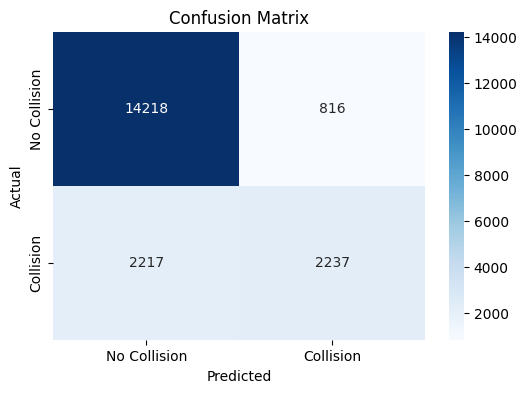

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Collision', 'Collision'], yticklabels=['No Collision', 'Collision'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


ROC-AUC: 0.87


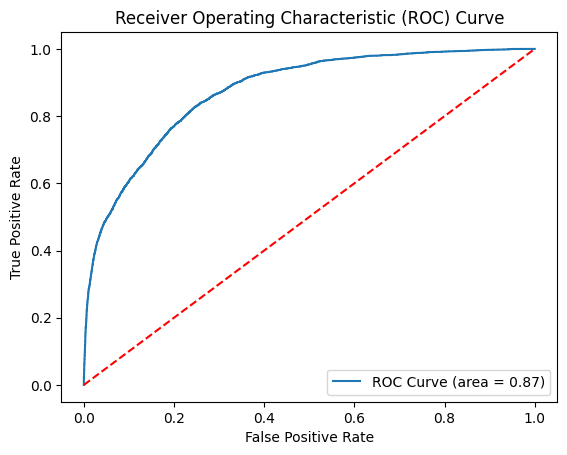

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [43]:
%pip install plotly


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
import tkinter as tk
from tkinter import messagebox
import numpy as np
import plotly.graph_objects as go
from tensorflow.keras.models import load_model
import joblib
import warnings

# Suppress feature names warning
warnings.filterwarnings("ignore", category=UserWarning)

# Load the trained LSTM model
model = load_model('collision_prediction_model.h5')

# Load the saved scaler
scaler = joblib.load('scaler.pkl')

# Initialize the main Tkinter window
root = tk.Tk()

# Set full-screen mode
root.state('zoomed')  # Windows specific full-screen, use root.attributes("-fullscreen", True) for others
root.title("Satellite Collision Prediction")

# Set theme colors and font
BACKGROUND_COLOR = "#1F1F1F"  # Dark background
FOREGROUND_COLOR = "#FFFFFF"  # White text color
ACCENT_COLOR = "#2196F3"  # Blue accent color
FONT = ("Helvetica", 16)
BUTTON_FONT = ("Helvetica", 14, "bold")

# Apply background color to the entire window
root.configure(bg=BACKGROUND_COLOR)

# Function to generate random debris coordinates, ensuring one debris point is high risk
def generate_random_debris_with_risk(satellite_coords, n=15, limit=10000):
    debris_coords = np.random.uniform(-limit, limit, size=(n, 3))
    
    # Ensure at least one high-risk debris by placing it very close to the satellite
    high_risk_debris = satellite_coords + np.random.uniform(-5, 5, size=(3))  # Place within 5 km
    debris_coords[0] = high_risk_debris  # Set the first debris as the high-risk one
    
    return debris_coords

# Function to calculate relative distance and velocity (dummy velocity for now)
def calculate_relative_distance(satellite_coords, debris_coords):
    distances = np.linalg.norm(debris_coords - satellite_coords, axis=1)
    relative_velocity = np.random.uniform(0, 2, len(debris_coords))  # Keep velocities low for high risk
    return distances, relative_velocity

# Function to preprocess data for LSTM prediction
def preprocess_for_prediction(satellite_coords, debris_coords, distances, velocities, sequence_length=10):
    processed_data = []
    for i in range(len(debris_coords)):
        relative_distance = distances[i]
        relative_acceleration = velocities[i]  # Placeholder for acceleration
        rolling_avg_speed = np.mean(velocities[:i+1]) if i >= 1 else velocities[i]  # Rolling avg speed
        delta_risk = np.random.uniform(0, 1)  # Placeholder for delta risk
        weighted_distance = relative_distance / (relative_distance + 1)

        # Create input feature row
        row = [relative_distance, relative_acceleration, rolling_avg_speed, delta_risk, weighted_distance]
        processed_data.append(row)
    
    # Debug: Print the features for the first debris (close debris)
    print(f"Features for high-risk debris (first debris): {processed_data[0]}")

    # If there are not enough debris points to generate sequences, return an empty array
    if len(processed_data) < sequence_length:
        return np.array([])  # Return empty array to avoid model errors

    # Scale the features using the loaded scaler
    processed_data = scaler.transform(np.array(processed_data))

    # Generate sequences for LSTM input
    sequences = []
    for i in range(len(processed_data) - sequence_length):
        sequences.append(processed_data[i:i+sequence_length])

    return np.array(sequences)

# Function to handle predictions and visualization
def visualize_and_predict():
    # Get satellite coordinates from user input
    try:
        sat_x = float(entry_x.get())
        sat_y = float(entry_y.get())
        sat_z = float(entry_z.get())
    except ValueError:
        messagebox.showerror("Input Error", "Please enter valid numbers for the coordinates.")
        return
    
    satellite_coords = np.array([sat_x, sat_y, sat_z])

    # Generate random debris coordinates with at least one high-risk debris
    debris_coords = generate_random_debris_with_risk(satellite_coords)

    # Calculate relative distances and velocities
    relative_distances, relative_velocities = calculate_relative_distance(satellite_coords, debris_coords)

    # Preprocess data for model prediction
    sequences = preprocess_for_prediction(satellite_coords, debris_coords, relative_distances, relative_velocities)

    # Check if sequences were generated
    if sequences.size == 0:
        messagebox.showinfo("Error", "Not enough data to generate sequences for prediction.")
        return

    # Make predictions with the model
    predictions = model.predict(sequences)
    print(predictions)

    # Initialize plotly figure for 3D plotting
    fig = go.Figure()

    # Plot satellite
    fig.add_trace(go.Scatter3d(
        x=[satellite_coords[0]], y=[satellite_coords[1]], z=[satellite_coords[2]],
        mode='markers',
        marker=dict(size=8, color='blue'),
        name='Satellite'
    ))

    # Predict collisions and plot debris
    num_predictions = len(predictions)

    for i in range(num_predictions):  # Iterate over available predictions
        pred = predictions[i]  # Prediction for this debris
        if pred < 0.05:  # Collision risk
            fig.add_trace(go.Scatter3d(
                x=[debris_coords[i, 0]], y=[debris_coords[i, 1]], z=[debris_coords[i, 2]],
                mode='markers',
                marker=dict(size=6, color='red'),
                name='Debris (Collision Risk)'
            ))
        else:
            fig.add_trace(go.Scatter3d(
                x=[debris_coords[i, 0]], y=[debris_coords[i, 1]], z=[debris_coords[i, 2]],
                mode='markers',
                marker=dict(size=6, color='green'),
                name='Debris (No Risk)'
            ))

    # Add layout for plotly figure
    fig.update_layout(
        scene=dict(
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate',
            zaxis_title='Z Coordinate',
        ),
        title='Satellite and Debris Collision Visualization',
    )

    # Show the interactive plot
    fig.show()

# ---------------------- GUI Design -----------------------

# Header label with modern style
header_label = tk.Label(root, text="Satellite Collision Prediction System", font=("Helvetica", 28, "bold"), bg=BACKGROUND_COLOR, fg=ACCENT_COLOR)
header_label.pack(pady=20)

# Frame for input fields
input_frame = tk.Frame(root, bg=BACKGROUND_COLOR)
input_frame.pack(pady=20)

# X Coordinate input
label_x = tk.Label(input_frame, text="Enter X Coordinate:", font=FONT, bg=BACKGROUND_COLOR, fg=FOREGROUND_COLOR)
label_x.grid(row=0, column=0, padx=10, pady=10)
entry_x = tk.Entry(input_frame, font=FONT, bg="#333", fg=FOREGROUND_COLOR)
entry_x.grid(row=0, column=1, padx=10, pady=10)

# Y Coordinate input
label_y = tk.Label(input_frame, text="Enter Y Coordinate:", font=FONT, bg=BACKGROUND_COLOR, fg=FOREGROUND_COLOR)
label_y.grid(row=1, column=0, padx=10, pady=10)
entry_y = tk.Entry(input_frame, font=FONT, bg="#333", fg=FOREGROUND_COLOR)
entry_y.grid(row=1, column=1, padx=10, pady=10)

# Z Coordinate input
label_z = tk.Label(input_frame, text="Enter Z Coordinate:", font=FONT, bg=BACKGROUND_COLOR, fg=FOREGROUND_COLOR)
label_z.grid(row=2, column=0, padx=10, pady=10)
entry_z = tk.Entry(input_frame, font=FONT, bg="#333", fg=FOREGROUND_COLOR)
entry_z.grid(row=2, column=1, padx=10, pady=10)

# Submit button with style
btn_visualize = tk.Button(root, text="Generate Debris and Predict Collisions", font=BUTTON_FONT, bg=ACCENT_COLOR, fg=FOREGROUND_COLOR, command=visualize_and_predict)
btn_visualize.pack(pady=30)

# Footer label
footer_label = tk.Label(root, text="© 2024 Rohan Menon", font=("Helvetica", 12), bg=BACKGROUND_COLOR, fg=FOREGROUND_COLOR)
footer_label.pack(pady=20)

# Start the Tkinter loop
root.mainloop()


Features for high-risk debris (first debris): [3.290250756732633, 0.9445922787861647, 0.9445922787861647, 0.0517684064590086, 0.766913391150689]
1/1 [==============================] - 1s 1s/step
[[0.01899097]
 [0.05970649]
 [0.05970649]
 [0.05970649]
 [0.05970649]]
